<a href="https://colab.research.google.com/github/unique-subedi/gene-expression/blob/main/Vinod_gene_expression_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import datetime
import time
import math
import numpy as np
from numpy import linalg as LA
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import scipy.stats as stats
import statsmodels.api as sm

In [2]:
!pip install qnorm
import qnorm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install pyreadr
import pyreadr
urllib.request.urlretrieve("https://raw.githubusercontent.com/unique-subedi/gene-expression/main/data/brain.rda", "brain.rda")
brain = pyreadr.read_r("brain.rda")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
expression = pd.DataFrame(brain["expression"])
genes = pd.DataFrame(brain["genes"])
samples = pd.DataFrame(brain["samples"])

In [45]:
genes_Y_crom = genes[genes.chrom == "Y"].index
genes_bac_index = genes[genes.chrom.isnull()].index
mean_bac_exp = expression[genes_bac_index].mean(axis=1)
std_bac_exp = expression[genes_bac_index].std(axis=1)
expression_norm =  (expression - mean_bac_exp.values[:, None]).divide(std_bac_exp, axis=0)
expression_qnorm = qnorm.quantile_normalize(expression, axis=0)

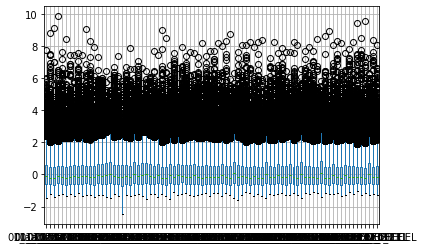

In [46]:
# expression.T.boxplot()
expression_norm.T.boxplot()
# expression_qnorm.T.boxplot()

In [ ]:
express_norm_samp = pd.concat([expression_qnorm, samples], axis=1)
express_samp_loc = express_norm_samp
c = 0
for tissue in express_samp_loc["region"].unique():
  print(tissue)
  df_male = express_samp_loc[(express_samp_loc.region == tissue) & (express_samp_loc.sex == "male")]
  df_female = express_samp_loc[(express_samp_loc.region == tissue) & (express_samp_loc.sex == "female")]

  male_mean = expression_qnorm.loc[df_male.index].mean()
  female_mean = expression_qnorm.loc[df_female.index].mean()

  diff = np.abs(male_mean - female_mean)
  diff = diff.sort_values(ascending=False)
  top_10 = diff.iloc[:10]
  op_chrom = genes.loc[top_10.keys()].loc[:, 'chrom'].values
  op_genes = genes.loc[top_10.keys()].loc[:, 'sym'].values
  chrom_counter = Counter(op_chrom)
  count = np.sum([chrom_counter[key] for key, value in chrom_counter.items() if key in ["X", "Y", "X Y"]])
  print(count)
  print(op_chrom, op_genes)
  print("")
  c += 1





A.C. cortex
3
['Y', 'Y', '11', '16hba1', '3', 'X', '12', '6', '8', '11']
Categories (39, object): ['1', '10', '10ak*', '10ptp*', ..., 'X', 'X Y', 'Y', 'na'] ['RPS4Y1', 'DDX3Y', 'HBB', NaN, 'MOBP', 'PLP1', 'GAPDH', 'RPS12', 'ENPP2', 'HBB']
Categories (8783, object): ['AADAC', 'AAK1', 'AAMP', 'AANAT', ..., 'ZYX', 'ZZEF1', 'ZZZ3', 'psiTPTE22']

cerebellum
3
['Y', 'Y', '11', 'X', '11', '16hba1', '4', '18', '17', '11']
Categories (39, object): ['1', '10', '10ak*', '10ptp*', ..., 'X', 'X Y', 'Y', 'na'] ['RPS4Y1', 'DDX3Y', 'HBB', 'PLP1', 'HBB', NaN, 'SPP1', 'MBP', 'GFAP', 'CRYAB']
Categories (8783, object): ['AADAC', 'AAK1', 'AAMP', 'AANAT', ..., 'ZYX', 'ZZEF1', 'ZZZ3', 'psiTPTE22']

D.L.P.F. cortex
4
['Y', 'Y', '11', '16hba1', '2', '11', '4', '2', 'Y', 'X']
Categories (39, object): ['1', '10', '10ak*', '10ptp*', ..., 'X', 'X Y', 'Y', 'na'] ['RPS4Y1', 'DDX3Y', 'HBB', NaN, 'IGFBP5', 'HBB', 'SPP1', 'IGFBP5', 'KDM5D', 'XIST']
Categories (8783, object): ['AADAC', 'AAK1', 'AAMP', 'AANAT', ..., 'ZY

In [ ]:
express_norm_samp = pd.concat([expression_norm, samples], axis=1)
express_samp_loc = express_norm_samp
c = 0
for tissue in express_samp_loc["region"].unique():
  print(tissue)
  df_male = express_samp_loc[(express_samp_loc.region == tissue) & (express_samp_loc.sex == "male")]
  df_female = express_samp_loc[(express_samp_loc.region == tissue) & (express_samp_loc.sex == "female")]

  unique_genes = expression_norm.columns
  p_values= []

  for gene in unique_genes:
    # stat, p = stats.ttest_ind(a=expression_norm.loc[df_male.index][gene], b=expression_norm.loc[df_female.index][gene], equal_var=False)
    stat, p = stats.ks_2samp(expression_norm.loc[df_male.index][gene], expression_norm.loc[df_female.index][gene])
    p_values.append((p, gene))

  sorted_pval = sorted(p_values, key=lambda tup: tup[0])
  top10genes = [tup[1] for tup in sorted_pval[:10]]
  # print(top10genes)

  op_chrom = genes.loc[top10genes].loc[:, 'chrom'].values
  op_genes = genes.loc[top10genes].loc[:, 'sym'].values
  chrom_counter = Counter(op_chrom)
  count = np.sum([chrom_counter[key] for key, value in chrom_counter.items() if key in ["X", "Y", "X Y"]])
  print(count)
  print(op_chrom, op_genes)
  print("")
  c += 1





A.C. cortex
8
['Y', 'Y', 'Y', 'Y', 'X', 'Y', '20', 'Y', '8', 'Y']
Categories (39, object): ['1', '10', '10ak*', '10ptp*', ..., 'X', 'X Y', 'Y', 'na'] ['UTY', 'DDX3Y', 'RPS4Y1', 'KDM5D', 'XIST', 'USP9Y', 'TCFL5', 'EIF1AY', 'CRH', 'TTTY15']
Categories (8783, object): ['AADAC', 'AAK1', 'AAMP', 'AANAT', ..., 'ZYX', 'ZZEF1', 'ZZZ3', 'psiTPTE22']

cerebellum
7
['Y', 'Y', 'Y', 'X', 'Y', '17', 'Y', '20', '6', 'Y']
Categories (39, object): ['1', '10', '10ak*', '10ptp*', ..., 'X', 'X Y', 'Y', 'na'] ['DDX3Y', 'RPS4Y1', 'KDM5D', 'XIST', 'UTY', 'JMJD6', 'TTTY15', 'HNF4A', 'CD24', 'USP9Y']
Categories (8783, object): ['AADAC', 'AAK1', 'AAMP', 'AANAT', ..., 'ZYX', 'ZZEF1', 'ZZZ3', 'psiTPTE22']

D.L.P.F. cortex
9
['Y', 'Y', 'Y', 'X', 'Y', 'Y', 'Y', 'X', '4', 'Y']
Categories (39, object): ['1', '10', '10ak*', '10ptp*', ..., 'X', 'X Y', 'Y', 'na'] ['DDX3Y', 'RPS4Y1', 'KDM5D', 'XIST', 'UTY', 'USP9Y', 'TTTY15', 'DUSP9', 'TMPRSS11D', 'NLGN4Y']
Categories (8783, object): ['AADAC', 'AAK1', 'AAMP', 'AANAT', ..

In [ ]:
express_norm_samp = pd.concat([expression_qnorm, samples], axis=1)
express_samp_loc = express_norm_samp
c = 0
for tissue in express_samp_loc["region"].unique():
  print(tissue)
  df_male = express_samp_loc[(express_samp_loc.region == tissue) & (express_samp_loc.sex == "male")]
  df_female = express_samp_loc[(express_samp_loc.region == tissue) & (express_samp_loc.sex == "female")]

  unique_genes = expression_qnorm.columns
  p_values= []

  for gene in unique_genes:
    # stat, p = stats.ttest_ind(a=expression_qnorm.loc[df_male.index][gene], b=expression_qnorm.loc[df_female.index][gene], equal_var=False)
    stat, p = stats.ks_2samp(expression_qnorm.loc[df_male.index][gene], expression_qnorm.loc[df_female.index][gene])
    p_values.append((p, gene))

  sorted_pval = sorted(p_values, key=lambda tup: tup[0])
  top10genes = [tup[1] for tup in sorted_pval[:10]]

  op_chrom = genes.loc[top10genes].loc[:, 'chrom'].values
  op_genes = genes.loc[top10genes].loc[:, 'sym'].values
  chrom_counter = Counter(op_chrom)
  count = np.sum([chrom_counter[key] for key, value in chrom_counter.items() if key in ["X", "Y", "X Y"]])
  print(count)
  print(op_chrom, op_genes)
  print("")
  c += 1





A.C. cortex


#OLS

In [64]:
samples

,patient,sex,region,lab,chip.version
rownames,,,,,
01_a_D_f_2.CEL,patient_01,female,A.C. cortex,Davis,v2
01_a_I_f_2.CEL,patient_01,female,A.C. cortex,Irvine,v2
01_a_M_f_1.CEL,patient_01,female,A.C. cortex,Michigan,v1
01_c_D_f_1.CEL,patient_01,female,cerebellum,Davis,v1
01_c_I_f_2.CEL,patient_01,female,cerebellum,Irvine,v2
...,...,...,...,...,...
10_c_I_f_2.CEL,patient_10,female,cerebellum,Irvine,v2
10_c_M_f_1.CEL,patient_10,female,cerebellum,Michigan,v1
10_d_D_f_2.CEL,patient_10,female,D.L.P.F. cortex,Davis,v2


expression

In [41]:
#need to create a design matrix - model 
# expression = beta_1*gender + beta_2* lab + beta_3* tissue * beta_4 * chrom + beta_5 * chip_version

#train one model per gene. 

#so need to make this dataset
human_genes = genes[genes.chrom.notnull() & genes.sym.notnull()].index;
#est2.conf_int(alpha=0.05, cols=None)

coef_gene = []
for gene in human_genes[:]:
  samples_tmp = samples.drop(columns= ["patient"]);
  one_hot_encoding = pd.get_dummies(samples_tmp);
  one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", 'chip.version_v2', "region_cerebellum", "lab_Davis"]);
  # one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", 'chip.version_v2', "patient_patient_10", "region_cerebellum", "lab_Davis"]);
  X = sm.add_constant(one_hot_encoding);
  model = sm.OLS(expression[gene],X);
  results = model.fit();
  lcb = results.conf_int(alpha= 0.001).loc["sex_male"][0]
  ucb = results.conf_int(alpha= 0.001).loc["sex_male"][1]
  if not lcb < 0 < ucb:
    coef_gene.append((gene, np.abs(results.params["sex_male"]), lcb, ucb))


In [42]:
  sorted_coef_gene = sorted(coef_gene, key=lambda tup: tup[1])
  print(sorted_coef_gene[-10:])
  top10genes = [tup[0] for tup in sorted_coef_gene[-10:]]
  op_chrom = genes.loc[top10genes].loc[:, 'chrom'].values
  op_genes = genes.loc[top10genes].loc[:, 'sym'].values

  print(op_chrom, op_genes)

[('38446_at', 0.32211163562325, -0.6392439071327769, -0.004979364113723184), ('32052_at', 0.6618093936031971, -1.2418658692260938, -0.08175291798030049), ('38355_at', 0.8080392266143466, 0.40988997154483925, 1.206188481683854), ('41214_at', 1.198685352333169, 0.8018963739565279, 1.5954743307098103)]
['X', '11', 'Y', 'Y']
Categories (39, object): ['1', '10', '10ak*', '10ptp*', ..., 'X', 'X Y', 'Y', 'na'] ['XIST', 'HBB', 'DDX3Y', 'RPS4Y1']
Categories (8783, object): ['AADAC', 'AAK1', 'AAMP', 'AANAT', ..., 'ZYX', 'ZZEF1', 'ZZZ3', 'psiTPTE22']


expression_norm

In [60]:
#need to create a design matrix - model 
# expression = beta_1*gender + beta_2* lab + beta_3* tissue * beta_4 * chrom + beta_5 * chip_version

#train one model per gene. 

#so need to make this dataset
human_genes = genes[genes.chrom.notnull() & genes.sym.notnull()].index;
#est2.conf_int(alpha=0.05, cols=None)

coef_gene = []
for gene in human_genes[:]:
  samples_tmp = samples.drop(columns= ["patient"]);
  one_hot_encoding = pd.get_dummies(samples_tmp);
  one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", 'chip.version_v2', "region_cerebellum", "lab_Davis"]);
  # one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", 'chip.version_v2', "patient_patient_10", "region_cerebellum", "lab_Davis"]);
  X = sm.add_constant(one_hot_encoding);
  model = sm.OLS(expression[gene],X);
  results = model.fit();
  lcb = results.conf_int(alpha= 0.05).loc["lab_Michigan"][0]
  ucb = results.conf_int(alpha= 0.05).loc["lab_Michigan"][1]
  # if not lcb < 0 < ucb:
  coef_gene.append((gene, np.abs(results.params["lab_Michigan"] - results.params["lab_Irvine"]), lcb, ucb))


In [61]:
  sorted_coef_gene = sorted(coef_gene, key=lambda tup: tup[1])
  print(sorted_coef_gene[-10:])

[('39332_at', 4.47904464885951, -2.861892868285674, -1.869963654207997), ('38032_at', 4.480369541215368, -3.0167140310342293, -1.9652224158591367), ('38711_at', 4.480434385659045, -3.931502010098435, -2.89440882356684), ('38406_f_at', 4.480728639317509, -2.356090694292533, -1.4555582590719984), ('36410_f_at', 4.502172403652644, -2.2511984979069717, -1.4052621836064687), ('38708_at', 4.590756672580022, -3.6366487312536155, -2.5655383131606224), ('36285_at', 4.620910422292189, -3.0267875594923352, -1.8557433924323363), ('35778_at', 4.633202311285724, -3.7011445550498294, -2.67724605636883), ('38308_g_at', 4.640368895846539, -2.868998385275601, -1.575558789557934), ('37760_at', 4.673930828643323, -3.185903396188331, -2.29050951082583)]
